# Machine learning model for Wave Energy Converters

This notebook contains the preparation of machine learning model for data set, which consists of positions and absorbed power outputs of wave energy converters (WECs) in four real wave scenarios from the souther coast of Australia. 
The dat set is publicliy available here:
<br/>
Neshat, M., Wagner, M., & Alexander, B. (2018). Wave Energy Converters [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5831S.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.engine import train

# Exploratory data analysis
We begin with preparing correct labels for our data set.
<br/>

In [2]:
labelsX = [f"X{i}" for i in range(1, 17)]
labelsY = [f"Y{i}" for i in range(1, 17)]
labelsP = [f"P{i}" for i in range(1, 17)]
labelsZ = "Powerall"
labels = labelsX + labelsY + labelsP
labels.append(labelsZ)
print(labels)

# adelaide_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Adelaide_Data.csv')
# perth_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Perth_Data.csv')
# sydney_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Sydney_Data.csv')
# tasmania_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Tasmania_Data.csv')

adelaide_df = pd.read_csv('Adelaide_Data.csv')
perth_df = pd.read_csv('Perth_Data.csv')
sydney_df = pd.read_csv('Sydney_Data.csv')
tasmania_df = pd.read_csv('Tasmania_Data.csv')


adelaide_df.columns = labels
perth_df.columns = labels
sydney_df.columns = labels
tasmania_df.columns = labels

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'Powerall']


In [3]:
adelaide_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,P8,P9,P10,P11,P12,P13,P14,P15,P16,Powerall
0,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,83920.1033,80968.0044,87108.1328,68065.1856,99061.3812,77549.1426,99013.1628,78234.4337,84633.6493,1340929.765
1,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,97358.7395,93437.7170,69940.2554,92864.1192,60887.8095,72306.6556,81151.1515,83030.9726,94779.6131,1352031.511
2,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,80399.3841,89349.6141,85048.3860,70038.2271,92797.3569,97653.8121,74903.3740,71690.6549,96220.4768,1396754.375
3,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,97088.1761,81187.3982,63591.6729,92418.1977,82454.8256,97091.7749,85937.5437,66823.1572,93683.0996,1355708.577
4,370.1551,438.7171,222.3375,153.1610,429.7656,478.7805,303.1690,448.9657,98.8592,29.9884,...,97335.9836,70670.4876,57081.2420,86038.3420,83643.1803,97737.5596,85684.3216,57476.9499,85025.9075,1308546.042


Checkikg the missing values:

In [4]:
frames = [adelaide_df, perth_df, sydney_df, tasmania_df]
check = pd.Series
for frame in frames:
    check = frame.isna().mean()
    print(dict(check))


{'X1': 0.0, 'X2': 0.0, 'X3': 0.0, 'X4': 0.0, 'X5': 0.0, 'X6': 0.0, 'X7': 0.0, 'X8': 0.0, 'X9': 0.0, 'X10': 0.0, 'X11': 0.0, 'X12': 0.0, 'X13': 0.0, 'X14': 0.0, 'X15': 0.0, 'X16': 0.0, 'Y1': 0.0, 'Y2': 0.0, 'Y3': 0.0, 'Y4': 0.0, 'Y5': 0.0, 'Y6': 0.0, 'Y7': 0.0, 'Y8': 0.0, 'Y9': 0.0, 'Y10': 0.0, 'Y11': 0.0, 'Y12': 0.0, 'Y13': 0.0, 'Y14': 0.0, 'Y15': 0.0, 'Y16': 0.0, 'P1': 0.0, 'P2': 0.0, 'P3': 0.0, 'P4': 0.0, 'P5': 0.0, 'P6': 0.0, 'P7': 0.0, 'P8': 0.0, 'P9': 0.0, 'P10': 0.0, 'P11': 0.0, 'P12': 0.0, 'P13': 0.0, 'P14': 0.0, 'P15': 0.0, 'P16': 0.0, 'Powerall': 0.0}
{'X1': 0.0, 'X2': 0.0, 'X3': 0.0, 'X4': 0.0, 'X5': 0.0, 'X6': 0.0, 'X7': 0.0, 'X8': 0.0, 'X9': 0.0, 'X10': 0.0, 'X11': 0.0, 'X12': 0.0, 'X13': 0.0, 'X14': 0.0, 'X15': 0.0, 'X16': 0.0, 'Y1': 0.0, 'Y2': 0.0, 'Y3': 0.0, 'Y4': 0.0, 'Y5': 0.0, 'Y6': 0.0, 'Y7': 0.0, 'Y8': 0.0, 'Y9': 0.0, 'Y10': 0.0, 'Y11': 0.0, 'Y12': 0.0, 'Y13': 0.0, 'Y14': 0.0, 'Y15': 0.0, 'Y16': 0.0, 'P1': 0.0, 'P2': 0.0, 'P3': 0.0, 'P4': 0.0, 'P5': 0.0, 'P6': 0.0, 

In [5]:
adelaide_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,P8,P9,P10,P11,P12,P13,P14,P15,P16,Powerall
count,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.00000,71998.000000,71998.000000,71998.000000,71998.000000,...,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,7.199800e+04
mean,281.278434,279.316799,294.138170,263.820014,290.190835,246.81052,252.474533,322.613080,280.746168,288.405246,...,88436.614802,88332.383742,87564.257977,88660.580440,88425.330170,87185.332906,87704.044108,89191.016479,88471.341006,1.410073e+06
std,178.320730,178.037942,182.138518,194.869224,179.635262,191.37862,178.340115,178.435158,190.274938,178.158481,...,10108.714997,10156.727576,10174.942637,10515.851087,10489.615606,10565.592524,10430.137566,10442.295312,10572.653000,5.600749e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,51444.747000,51304.021600,49409.891500,49814.045300,51660.410600,50205.352800,51141.599700,50628.552800,47273.983600,1.191378e+06
25%,117.006825,116.477225,116.269200,76.570500,123.092425,67.49445,89.111750,166.917500,103.627400,126.430400,...,81445.599325,81102.055325,80546.816775,80803.156425,80789.259225,79083.946125,79920.262800,81584.169325,80400.514400,1.371209e+06
50%,282.731850,280.674850,315.467050,247.231900,286.194300,214.91815,233.673750,356.337700,267.173600,288.203900,...,90310.888500,90083.739600,88073.889100,91008.722450,89940.659550,87663.436400,89004.129150,92113.493100,90698.590550,1.402170e+06
75%,437.294500,444.122000,455.154275,444.659350,460.148200,433.31165,408.797950,481.671800,464.014100,448.372850,...,97418.742850,97448.086300,97336.088325,97813.297875,97720.390650,97475.936600,97501.542600,98072.961125,97663.106325,1.446065e+06
max,566.000000,566.000000,566.000000,566.000000,566.000000,566.00000,566.000000,566.000000,566.000000,566.000000,...,105790.374500,105526.299600,105420.107400,105395.279300,105539.986600,105447.760000,105301.202500,104602.318800,105390.327100,1.583052e+06


In [6]:
for frame in frames:
    dtypes = dict(frame.dtypes)
    for key, values in dtypes.items():
        if values != 'float64':
            print(frame.dtypes)

As we can see all data types in dataframes are numeric values (float64)

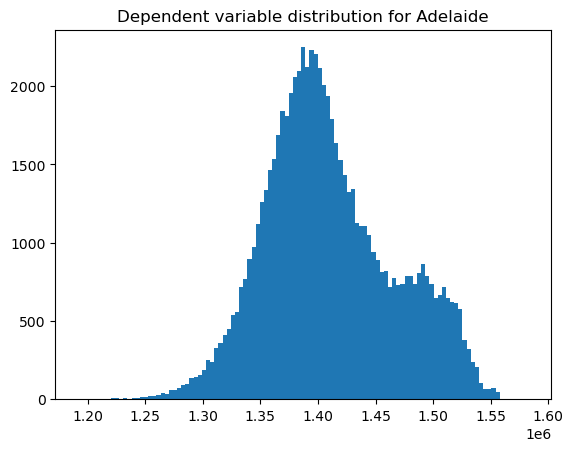

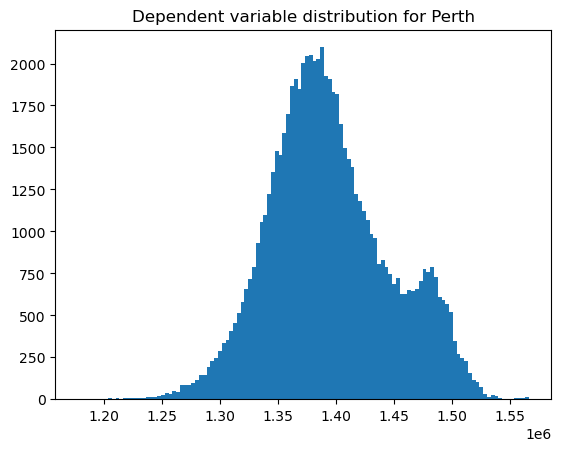

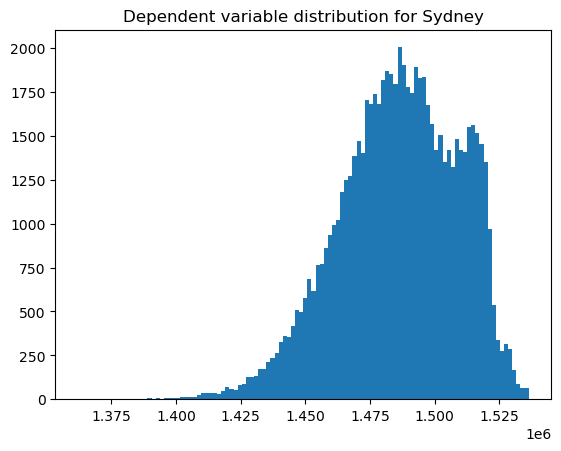

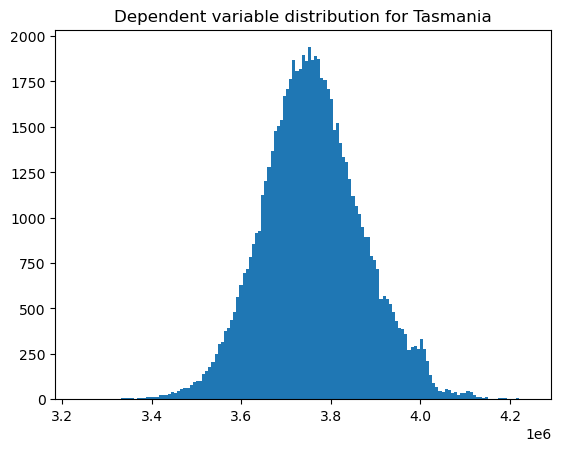

In [7]:
frames_dict = {"Adelaide": adelaide_df, "Perth": perth_df, "Sydney": sydney_df, "Tasmania": tasmania_df}
for key, frame in frames_dict.items():
    dep_var = frame['Powerall']
    plt.hist(frame['Powerall'], bins = 'auto')
    plt.title(f'Dependent variable distribution for {key}')
    plt.show()

In [8]:
class PipelineWrapper:
    def __init__(self, df: pd.DataFrame, labels, size, val_size, random):
        self.df = df
        self.labels = labels
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        self.process()
        self.split_sets(size, val_size, random)
    
        
    
    def process(self):
        self.X = self.df.drop('Powerall', axis=1)
        self.X = self.X.drop([i for i in self.labels], axis= 1)
        self.y = self.df['Powerall']
    
    def split_sets(self, size, val_size, random):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=size, random_state=random
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=val_size, random_state=random)
    
    def train_evaluate_linear_regression(self):

        # Train model
        model_lr = LinearRegression()
        model_lr.fit(self.X_train, self.y_train)

        # Predict
        y_pred = model_lr.predict(self.X_test)

        # Evaluate
        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = root_mean_squared_error(self.y_test, y_pred)

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return model_lr, metrics

    
        

        

In [11]:
cities = [adelaide_df, perth_df, sydney_df, tasmania_df]
for city in cities:
    result = PipelineWrapper(city, labels = labelsP, size=20, val_size=25, random=42)
    print(50* "=")
    result.train_evaluate_linear_regression()

R2 Score: 0.10211025281749264
Mean Absolute Percentage Error: 0.02969934301816643
Root Mean Squared Error: 52922.895090025246
R2 Score: 0.08581756640459048
Mean Absolute Percentage Error: 0.030110742904729627
Root Mean Squared Error: 49286.6019501993
R2 Score: 0.12704518575636126
Mean Absolute Percentage Error: 0.01155084433821371
Root Mean Squared Error: 20374.506820348335
R2 Score: 0.2320856285321572
Mean Absolute Percentage Error: 0.020103894576487077
Root Mean Squared Error: 100711.47445882087
